In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
from datetime import datetime
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    hamming_loss,
    jaccard_score,
)
import os
from tensorflow.keras.callbacks import ModelCheckpoint


Data preparation

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
movie_dataset = pd.read_csv("/content/drive/MyDrive/semestr 9/movie_dataset_prepared.csv")

In [32]:
movie_dataset.head()

movie_dataset

,genres_list,keywords_list,overview
0,"[28, 12, 14, 878]","[2964, 3801, 9840, 9882, 9951, 13065, 14643, 2...",in the 22nd century a paraplegic marine is dis...
1,"[12, 14, 28]","[2038, 3799, 179430]",captain barbossa long believed to be dead has ...
2,"[28, 12, 80]","[470, 818, 4289, 9663]",a cryptic message from bonds past sends him on...
3,"[28, 80, 18, 53]","[849, 949, 1308, 9715, 156395]",following the death of district attorney harve...
4,"[28, 12, 878]","[818, 3801, 7376, 9951, 10685, 207928, 209714]",john carter is a warweary former military capt...
...,...,...,...
4795,"[28, 80, 53]",[],el mariachi just wants to play his guitar and ...
4796,"[35, 10749]",[],a newlywed couples honeymoon is upended by the...
4797,"[35, 18, 10749, 10770]",[5340],signed sealed delivered introduces a dedicated...
4798,[],[],when ambitious new york attorney sam is sent t...


In [33]:
movie_dataset = movie_dataset[['overview', 'genres_list']].copy()

movie_dataset.head()

,overview,genres_list
0,in the 22nd century a paraplegic marine is dis...,"[28, 12, 14, 878]"
1,captain barbossa long believed to be dead has ...,"[12, 14, 28]"
2,a cryptic message from bonds past sends him on...,"[28, 12, 80]"
3,following the death of district attorney harve...,"[28, 80, 18, 53]"
4,john carter is a warweary former military capt...,"[28, 12, 878]"


In [34]:
all_genres = [g for g_list in movie_dataset["genres_list"] for g in g_list]
g_counts = Counter(all_genres)

frequent_genres = {g for g, count in g_counts.items() if count > 150}

movie_dataset["genres_list"] = movie_dataset["genres_list"].apply(
    lambda lst: [g for g in lst if g in frequent_genres]
)


In [35]:
# metod for oversampling imbalanced data

def oversample_multilabel(X, y, target_strategy="max", random_state=42):
    """
    Prosty oversampling dla multi-label:
    - X: np.array (n_samples, max_len)
    - y: np.array (n_samples, n_classes) z wartościami 0/1
    - target_strategy:
        "max"  -> każdą etykietę dociągamy do max liczności
        "mean" -> dociągamy do średniej liczności etykiet
    Zwraca: X_bal, y_bal
    """
    rng = np.random.default_rng(random_state)


    label_counts = y.sum(axis=0).astype(int)
    if target_strategy == "max":
        target = label_counts.max()
    elif target_strategy == "mean":
        target = int(label_counts.mean())
    else:
        raise ValueError("target_strategy must be 'max' or 'mean'")

    n_classes = y.shape[1]


    idx_per_label = {
        c: np.where(y[:, c] == 1)[0]
        for c in range(n_classes)
    }

    X_list = [X]
    y_list = [y]

    for c in range(n_classes):
        deficit = target - label_counts[c]
        if deficit <= 0:
            continue


        candidate_idx = idx_per_label[c]
        if len(candidate_idx) == 0:
            continue


        sampled_idx = rng.choice(candidate_idx, size=deficit, replace=True)
        X_list.append(X[sampled_idx])
        y_list.append(y[sampled_idx])


    X_bal = np.concatenate(X_list, axis=0)
    y_bal = np.concatenate(y_list, axis=0)

    perm = rng.permutation(len(X_bal))
    X_bal = X_bal[perm]
    y_bal = y_bal[perm]

    return X_bal, y_bal

--- Sequence Length Statistics ---
Mean length: 51.98 words
Max length: 175 words
------------------------------
90% of descriptions fit in: 85 words
95% of descriptions fit in: 107 words  <-- RECOMMENDED FOR MAX_LEN
98% of descriptions fit in: 129 words


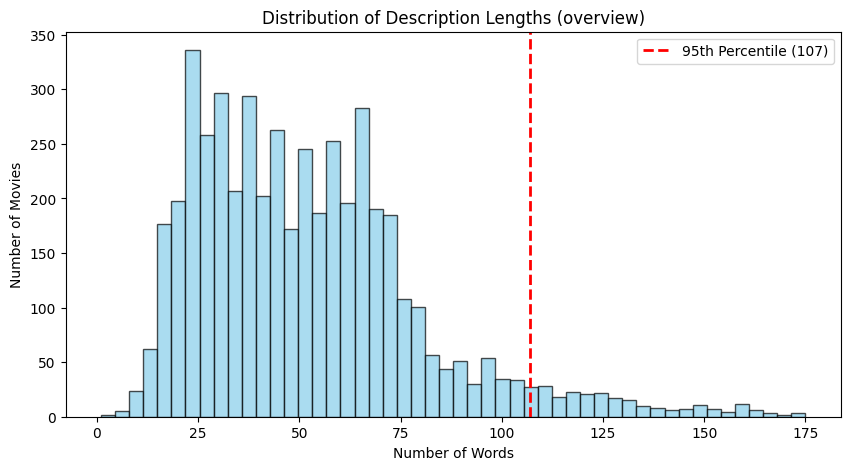

In [36]:
# defining max_len value for lstm

# 1. Calculate sequence lengths
seq_lengths = [len(str(text).split()) for text in movie_dataset['overview']]


# 2. Calculate percentiles
p90 = np.percentile(seq_lengths, 90)
p95 = np.percentile(seq_lengths, 95)
p98 = np.percentile(seq_lengths, 98)
max_val = np.max(seq_lengths)

# 3. Print results
print(f"--- Sequence Length Statistics ---")
print(f"Mean length: {np.mean(seq_lengths):.2f} words")
print(f"Max length: {max_val} words")
print(f"-" * 30)
print(f"90% of descriptions fit in: {int(p90)} words")
print(f"95% of descriptions fit in: {int(p95)} words  <-- RECOMMENDED FOR MAX_LEN")
print(f"98% of descriptions fit in: {int(p98)} words")

# 4. Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(seq_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(p95, color='red', linestyle='dashed', linewidth=2, label=f'95th Percentile ({int(p95)})')
plt.title('Distribution of Description Lengths (overview)')
plt.xlabel('Number of Words')
plt.ylabel('Number of Movies')
plt.legend()
plt.show()

In [37]:
# createing small dataset for testing purposes

# movie_dataset_small = movie_dataset.sample(n=100, random_state=42)

# movie_dataset = movie_dataset_small

movie_dataset.head()

,overview,genres_list
0,in the 22nd century a paraplegic marine is dis...,"[[, 2, 8, ,, , 1, 2, ,, , 1, 4, ,, , 8, 7, ..."
1,captain barbossa long believed to be dead has ...,"[[, 1, 2, ,, , 1, 4, ,, , 2, 8, ]]"
2,a cryptic message from bonds past sends him on...,"[[, 2, 8, ,, , 1, 2, ,, , 8, 0, ]]"
3,following the death of district attorney harve...,"[[, 2, 8, ,, , 8, 0, ,, , 1, 8, ,, , 5, 3, ]]"
4,john carter is a warweary former military capt...,"[[, 2, 8, ,, , 1, 2, ,, , 8, 7, 8, ]]"


In [38]:
# tokenazation and padding for overwiew
movie_dataset['overview'] = movie_dataset['overview'].fillna('').astype(str)


# checking the number of unique words to better estimate size of the vocabulary (max_features)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(movie_dataset['overview'])
print("Unique words:", len(tokenizer.word_index))

Unique words: 23598


In [39]:
max_features = 20000
max_len = 128
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(movie_dataset['overview'].values)
X = tokenizer.texts_to_sequences(movie_dataset['overview'].values)
X = pad_sequences(X, max_len)

In [40]:
# multi-label binarization

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(movie_dataset["genres_list"])
genre_classes = mlb.classes_
num_classes = len(genre_classes)

y_for_split = np.argmax(y, axis=1)

In [41]:
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

Manually specified (non-default) hyperparameters of the model architecture:

- input_dim=10000 - sice of the vocabulary (based on the number of unique words)  
- output_dim=100 - length of embeding vector, value 100 is commonly use for the model. It was not tunned because of it low impact on model and to reduce computatino time  
- Dense(64, activation='relu') – a dense layer with ReLU activation (it allowes model to lern more complex representatinos)  
- Dense(num_classes, activation='sigmoid') - defining how many class we have, sigmoid for multi-label classification
- Nr of epochs - 15 (with early dtop added)

The parameters we will be tuning:

- the number of LSTM units  
- dropout - to reduce overfitting

In [42]:
SAVE_MODEL_DIR = "/content/drive/MyDrive/lstm_genres/models_3"
os.makedirs(SAVE_MODEL_DIR, exist_ok=True)

RESULTS_DIR = "/content/drive/MyDrive/lstm_genres/results_3"
os.makedirs(RESULTS_DIR, exist_ok=True)

param_grid = list(ParameterGrid({
    'lstm_units': [64, 128],
    'dropout_rate': [0.3, 0.5],
}))

fold_results = []
metrics_all = {
    'accuracy': {str(p): [] for p in param_grid},
    'precision': {str(p): [] for p in param_grid},
    'recall': {str(p): [] for p in param_grid},
    'f1': {str(p): [] for p in param_grid},
    'hamming_loss': {str(p): [] for p in param_grid},
    'f1_macro':          {str(p): [] for p in param_grid},
    'f1_micro':          {str(p): [] for p in param_grid},
    'precision_macro':   {str(p): [] for p in param_grid},
    'precision_micro':   {str(p): [] for p in param_grid},
    'recall_macro':      {str(p): [] for p in param_grid},
    'recall_micro':      {str(p): [] for p in param_grid},
    'hamming_accuracy':  {str(p): [] for p in param_grid},
    'jaccard_samples':   {str(p): [] for p in param_grid},
}


predictions_all = {str(p): {'y_true': [], 'y_pred': []} for p in param_grid}


def create_model(lstm_units, dropout_rate, num_classes, max_features, max_len):
    """Create Bidirectional LSTM model with given parameters"""
    model = Sequential([
        Embedding(input_dim=10000, output_dim=100),
        Bidirectional(LSTM(lstm_units, return_sequences=True)),
        Dropout(dropout_rate),
        Bidirectional(LSTM(lstm_units // 2)),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='sigmoid')  # Multi-label: sigmoid
    ])

    model.compile(
        loss='binary_crossentropy',  # Multi-label: binary_crossentropy
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    return model

# Grid Search with Cross-Validation
print("Starting Grid Search with Cross-Validation...\n")
print(f"Total combinations: {len(param_grid)}")
print(f"Total folds per combination: {n_splits}")
print(f"Total models to train: {len(param_grid) * n_splits}")
print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

results_file = 'grid_search_results.json'


for param_idx, params in enumerate(param_grid):
  p_str = str(params)

  print("="*80)
  print(f"COMBINATION {param_idx + 1}/{len(param_grid)}")
  print("="*80)
  print(f"Parameters: {params}")
  print(f"Started at: {datetime.now().strftime('%H:%M:%S')}")
  print("-"*80)

  for fold, (train_idx, val_idx) in enumerate(kf.split(X, y_for_split)):
    print(f"\n  FOLD {fold + 1}/{n_splits}")
    print(f"  Training samples: {len(train_idx)}, Validation samples: {len(val_idx)}")

    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    X_train_fold, y_train_fold = oversample_multilabel(
        X_train_fold,
        y_train_fold,
        target_strategy="mean",
        random_state=42
    )


    model = create_model(
            lstm_units=params['lstm_units'],
            dropout_rate=params['dropout_rate'],
            num_classes=num_classes,
            max_features=max_features,
            max_len = max_len
        )

    model_name = (
        f"lstm_units{params['lstm_units']}_"
        f"drop{params['dropout_rate']}_"
        f"fold{fold+1}.keras"
    )
    checkpoint_path = os.path.join(SAVE_MODEL_DIR, model_name)


    early_stop = EarlyStopping(
            monitor='val_loss',
            patience=6,
            restore_best_weights=True,
            verbose=0
        )

    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )

    print(f"  Training...")
    history = model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=30,
            batch_size=32,
            callbacks=[early_stop, checkpoint],
            verbose=1
        )

    # Show training summary
    final_epoch = len(history.history['loss'])
    print(f"\n  Completed {final_epoch} epochs (early stopped: {final_epoch < 15})")
    print(f"  Final training loss: {history.history['loss'][-1]:.4f}")
    print(f"  Final validation loss: {history.history['val_loss'][-1]:.4f}")
    print(f"  Best validation loss: {min(history.history['val_loss']):.4f}")

    y_pred_probs = model.predict(X_val_fold, verbose=0)
    y_pred = (y_pred_probs > 0.5).astype(int)  # Multi-label threshold

    predictions_all[p_str]['y_true'].extend(y_val_fold)
    predictions_all[p_str]['y_pred'].extend(y_pred)

    acc = accuracy_score(y_val_fold, y_pred)
    prec = precision_score(y_val_fold, y_pred, average='samples', zero_division=0)
    rec = recall_score(y_val_fold, y_pred, average='samples', zero_division=0)
    f1 = f1_score(y_val_fold, y_pred, average='samples', zero_division=0)
    h_loss = hamming_loss(y_val_fold, y_pred)
    f1_macro = f1_score(y_val_fold, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_val_fold, y_pred, average='micro', zero_division=0)
    prec_macro = precision_score(y_val_fold, y_pred, average='macro', zero_division=0)
    prec_micro = precision_score(y_val_fold, y_pred, average='micro', zero_division=0)
    rec_macro = recall_score(y_val_fold, y_pred, average='macro', zero_division=0)
    rec_micro = recall_score(y_val_fold, y_pred, average='micro', zero_division=0)
    h_acc = 1.0 - h_loss
    jacc = jaccard_score(y_val_fold, y_pred, average='samples')

    metrics_all['accuracy'][p_str].append(acc)
    metrics_all['precision'][p_str].append(prec)
    metrics_all['recall'][p_str].append(rec)
    metrics_all['f1'][p_str].append(f1)
    metrics_all['hamming_loss'][p_str].append(h_loss)
    metrics_all['f1_macro'][p_str].append(f1_macro)
    metrics_all['f1_micro'][p_str].append(f1_micro)
    metrics_all['precision_macro'][p_str].append(prec_macro)
    metrics_all['precision_micro'][p_str].append(prec_micro)
    metrics_all['recall_macro'][p_str].append(rec_macro)
    metrics_all['recall_micro'][p_str].append(rec_micro)
    metrics_all['hamming_accuracy'][p_str].append(h_acc)
    metrics_all['jaccard_samples'][p_str].append(jacc)

    print(f"\n  FOLD {fold + 1} RESULTS:")
    print(f"    Accuracy:      {acc:.4f}")
    print(f"    Precision:     {prec:.4f}")
    print(f"    Recall:        {rec:.4f}")
    print(f"    F1 Score:      {f1:.4f}")
    print(f"    Hamming Loss:  {h_loss:.4f}")
    print(f"    Hamming Accuracy:     {h_acc:.4f}")
    print(f"    F1 Macro:             {f1_macro:.4f}")
    print(f"    F1 Micro:             {f1_micro:.4f}")
    print(f"    Jaccard (samples):    {jacc:.4f}")

    fold_results.append({
            'fold': fold + 1,
            'accuracy': float(acc),
            'precision': float(prec),
            'recall': float(rec),
            'f1': float(f1),
            'hamming_loss': float(h_loss),
            'hamming_accuracy': float(h_acc),
            'f1_macro': float(f1_macro),
            'f1_micro': float(f1_micro),
            'precision_macro': float(prec_macro),
            'precision_micro': float(prec_micro),
            'recall_macro': float(rec_macro),
            'recall_micro': float(rec_micro),
            'jaccard_samples': float(jacc),
            'epochs_trained': final_epoch,
            'final_train_loss': float(history.history['loss'][-1]),
            'final_val_loss': float(history.history['val_loss'][-1])
        })

  avg_acc = np.mean(metrics_all['accuracy'][p_str])
  avg_prec = np.mean(metrics_all['precision'][p_str])
  avg_rec = np.mean(metrics_all['recall'][p_str])
  avg_f1 = np.mean(metrics_all['f1'][p_str])
  avg_h_loss = np.mean(metrics_all['hamming_loss'][p_str])
  avg_f1_macro = np.mean(metrics_all['f1_macro'][p_str])
  avg_f1_micro = np.mean(metrics_all['f1_micro'][p_str])
  avg_h_acc = np.mean(metrics_all['hamming_accuracy'][p_str])
  avg_jacc = np.mean(metrics_all['jaccard_samples'][p_str])

  print("\n" + "="*80)
  print(f"COMBINATION {param_idx + 1} SUMMARY")
  print("="*80)
  print(f"Parameters: {params}")
  print(f"Average Accuracy:      {avg_acc:.4f} (+/- {np.std(metrics_all['accuracy'][p_str]):.4f})")
  print(f"Average Precision:     {avg_prec:.4f} (+/- {np.std(metrics_all['precision'][p_str]):.4f})")
  print(f"Average Recall:        {avg_rec:.4f} (+/- {np.std(metrics_all['recall'][p_str]):.4f})")
  print(f"Average F1 Score:      {avg_f1:.4f} (+/- {np.std(metrics_all['f1'][p_str]):.4f})")
  print(f"Average Hamming Loss:  {avg_h_loss:.4f} (+/- {np.std(metrics_all['hamming_loss'][p_str]):.4f})")
  print(f"Average Hamming Accuracy: {avg_h_acc:.4f}")
  print(f"Average F1 Macro:         {avg_f1_macro:.4f}")
  print(f"Average F1 Micro:         {avg_f1_micro:.4f}")
  print(f"Average Jaccard (samples):{avg_jacc:.4f}")
  print(f"Completed at: {datetime.now().strftime('%H:%M:%S')}\n")

  # Save intermediate results to file (in case of crash)
  intermediate_results = {
      'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
      'completed_combinations': param_idx + 1,
      'total_combinations': len(param_grid),
      'params': params,
      'fold_results': fold_results,
      'summary': {
          'avg_accuracy': float(avg_acc),
          'std_accuracy': float(np.std(metrics_all['accuracy'][p_str])),
          'avg_precision': float(avg_prec),
          'avg_recall': float(avg_rec),
          'avg_f1': float(avg_f1),
          'std_f1': float(np.std(metrics_all['f1'][p_str])),
          'avg_hamming_loss': float(avg_h_loss),
          'avg_hamming_accuracy': float(avg_h_acc),
          'avg_f1_macro': float(avg_f1_macro),
          'avg_f1_micro': float(avg_f1_micro),
          'avg_jaccard_samples': float(avg_jacc),
      }
  }

  # Append to file
  results_file = os.path.join(RESULTS_DIR, "grid_search_results.json")

  try:
      with open(results_file, 'r') as f:
          all_results = json.load(f)
  except FileNotFoundError:
      all_results = []

  all_results.append(intermediate_results)

  with open(results_file, 'w') as f:
      json.dump(all_results, f, indent=2)

  print(f"✓ Results saved to {results_file}\n")


print("\n" + "="*80)
print("GRID SEARCH COMPLETED!")
print("="*80)
print(f"Finished at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

summary_df = pd.DataFrame({
    'params': list(metrics_all['f1'].keys()),
    'accuracy_mean': [np.mean(metrics_all['accuracy'][p]) for p in metrics_all['accuracy']],
    'accuracy_std': [np.std(metrics_all['accuracy'][p]) for p in metrics_all['accuracy']],
    'precision_mean': [np.mean(metrics_all['precision'][p]) for p in metrics_all['precision']],
    'recall_mean': [np.mean(metrics_all['recall'][p]) for p in metrics_all['recall']],
    'f1_mean': [np.mean(metrics_all['f1'][p]) for p in metrics_all['f1']],
    'f1_std': [np.std(metrics_all['f1'][p]) for p in metrics_all['f1']],
    'hamming_loss_mean': [np.mean(metrics_all['hamming_loss'][p]) for p in metrics_all['hamming_loss']],
    'f1_macro_mean':       [np.mean(metrics_all['f1_macro'][p]) for p in metrics_all['f1_macro']],
    'f1_micro_mean':       [np.mean(metrics_all['f1_micro'][p]) for p in metrics_all['f1_micro']],
    'hamming_accuracy_mean':[np.mean(metrics_all['hamming_accuracy'][p]) for p in metrics_all['hamming_accuracy']],
    'jaccard_samples_mean':[np.mean(metrics_all['jaccard_samples'][p]) for p in metrics_all['jaccard_samples']],
})

summary_df = summary_df.sort_values('f1_mean', ascending=False)

print("="*80)
print("CROSS-VALIDATION RESULTS (sorted by F1 score)")
print("="*80)
print(summary_df.to_string(index=False))

# Save final summary
summary_df.to_csv('final_grid_search_summary.csv', index=False)
print(f"\n✓ Final summary saved to 'final_grid_search_summary.csv'")

# Get best parameters
best_params_str = summary_df.iloc[0]['params']
best_params = eval(best_params_str)

print("\n" + "="*80)
print("BEST PARAMETERS")
print("="*80)
print(f"Parameters: {best_params}")
print(f"F1 Score: {summary_df.iloc[0]['f1_mean']:.4f} (+/- {summary_df.iloc[0]['f1_std']:.4f})")
print(f"Accuracy: {summary_df.iloc[0]['accuracy_mean']:.4f} (+/- {summary_df.iloc[0]['accuracy_std']:.4f})")

Starting Grid Search with Cross-Validation...

Total combinations: 4
Total folds per combination: 5
Total models to train: 20
Started at: 2025-11-30 10:58:20

COMBINATION 1/4
Parameters: {'dropout_rate': 0.3, 'lstm_units': 64}
Started at: 10:58:20
--------------------------------------------------------------------------------

  FOLD 1/5
  Training samples: 3840, Validation samples: 960
  Training...
Epoch 1/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0188 - loss: 0.5559
Epoch 1: val_loss improved from inf to 0.53149, saving model to /content/drive/MyDrive/lstm_genres/models_3/lstm_units64_drop0.3_fold1.keras
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.0188 - loss: 0.5558 - val_accuracy: 0.0000e+00 - val_loss: 0.5315
Epoch 2/30
295/297 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 4.3397e-04 - loss: 0.4270
Epoch 2: val_loss did not improve from 0.53149
297/297 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 4.3915e-04 - loss: 0.4267 - val_accuracy: 0.0031 - v

## Ewaluacja moich wyników  
Korzystając z metryki F1_macro i jaccard sample   
testów Friedmana oraz testó post-hoc Nemenyi

In [43]:
!pip install scikit-posthocs

In [44]:
import scikit_posthocs as sp
from scipy.stats import friedmanchisquare

In [45]:
key_metrics = ['f1_macro', 'jaccard_samples']

for metric in key_metrics:
    print("\n" + "="*80)
    print(f"STATISTICAL TESTS FOR: {metric.upper()}")
    print("="*80)

    df = pd.DataFrame(metrics_all[metric])

    # mean ranking
    means = df.mean().sort_values(ascending=False)
    print("\nŚrednie wartości:")
    print(means.round(4))

    # Friedman's test
    algorithms = [df[col].values for col in df.columns]

    stat, p_value = friedmanchisquare(*algorithms)
    print(f"\nTest Friedmana dla {metric}:")
    print(f"chi2 = {stat:.4f}, p-value = {p_value:.6f}")

    # post-hoc Nemenyi
    nemenyi = sp.posthoc_nemenyi_friedman(df.to_numpy())
    nemenyi_df = pd.DataFrame(nemenyi, index=df.columns, columns=df.columns)

    print(f"\nPost-hoc Nemenyi (p-values) – {metric}:")
    print(nemenyi_df.round(4))

    # save results
    nemenyi_path = os.path.join(RESULTS_DIR, f"nemenyi_{metric}.csv")
    nemenyi_df.to_csv(nemenyi_path)
    print(f"\nZapisano macierz Nemenyi do: {nemenyi_path}")


STATISTICAL TESTS FOR: F1_MACRO

Średnie wartości:
{'dropout_rate': 0.5, 'lstm_units': 64}     0.7063
{'dropout_rate': 0.3, 'lstm_units': 128}    0.7058
{'dropout_rate': 0.3, 'lstm_units': 64}     0.7040
{'dropout_rate': 0.5, 'lstm_units': 128}    0.7010
dtype: float64

Test Friedmana dla f1_macro:
chi2 = 1.3200, p-value = 0.724389

Post-hoc Nemenyi (p-values) – f1_macro:
                                          {'dropout_rate': 0.3, 'lstm_units': 64}  \
{'dropout_rate': 0.3, 'lstm_units': 64}                                       NaN   
{'dropout_rate': 0.3, 'lstm_units': 128}                                      NaN   
{'dropout_rate': 0.5, 'lstm_units': 64}                                       NaN   
{'dropout_rate': 0.5, 'lstm_units': 128}                                      NaN   

                                          {'dropout_rate': 0.3, 'lstm_units': 128}  \
{'dropout_rate': 0.3, 'lstm_units': 64}                                        NaN   
{'dropout_rate': 0.3, 'lst

In [46]:
configs = list(metrics_all['f1_macro'].keys())

comparison_rows = []

for cfg in configs:
    comparison_rows.append({
        'config': cfg,
        'f1_macro_mean': np.mean(metrics_all['f1_macro'][cfg]),
        'jaccard_mean': np.mean(metrics_all['jaccard_samples'][cfg])
    })

comparison_df = pd.DataFrame(comparison_rows)


comparison_df_sorted_f1 = comparison_df.sort_values('f1_macro_mean', ascending=False)
comparison_df_sorted_jaccard = comparison_df.sort_values('jaccard_mean', ascending=False)

best_f1 = comparison_df_sorted_f1.iloc[0]
best_jaccard = comparison_df_sorted_jaccard.iloc[0]

print("\n" + "="*90)
print("PORÓWNANIE MODELI – ŚREDNIE F1 MACRO I JACCARD")
print("="*90)
print(comparison_df.round(4).to_string(index=False))

print("\n" + "="*90)
print("NAJLEPSZY MODEL WG F1 MACRO")
print("="*90)
print(f"Config: {best_f1['config']}")
print(f"F1 Macro Mean: {best_f1['f1_macro_mean']:.4f}")
print(f"Jaccard Mean:  {best_f1['jaccard_mean']:.4f}")

print("\n" + "="*90)
print("NAJLEPSZY MODEL WG JACCARD SAMPLES")
print("="*90)
print(f"Config: {best_jaccard['config']}")
print(f"Jaccard Mean:  {best_jaccard['jaccard_mean']:.4f}")
print(f"F1 Macro Mean: {best_jaccard['f1_macro_mean']:.4f}")



PORÓWNANIE MODELI – ŚREDNIE F1 MACRO I JACCARD
                                  config  f1_macro_mean  jaccard_mean
 {'dropout_rate': 0.3, 'lstm_units': 64}         0.7040        0.6635
{'dropout_rate': 0.3, 'lstm_units': 128}         0.7058        0.6648
 {'dropout_rate': 0.5, 'lstm_units': 64}         0.7063        0.6701
{'dropout_rate': 0.5, 'lstm_units': 128}         0.7010        0.6652

NAJLEPSZY MODEL WG F1 MACRO
Config: {'dropout_rate': 0.5, 'lstm_units': 64}
F1 Macro Mean: 0.7063
Jaccard Mean:  0.6701

NAJLEPSZY MODEL WG JACCARD SAMPLES
Config: {'dropout_rate': 0.5, 'lstm_units': 64}
Jaccard Mean:  0.6701
F1 Macro Mean: 0.7063
